# Prerequisite

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder \
   .appName("Neural Network Model") \
   .config("spark.executor.memory", "3gb") \
   .getOrCreate()
   
sc = spark.sparkContext

In [ ]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Library

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd

# 1. Business Understanding

ธุรกิจต้องการได้รับ Machine Learning Model ที่ทำให้ทราบล่วงหน้าว่า ลูกค้าที่กำลังเลือกดูสินค้าอยู่ จะซื้อหรือไม่ซื้อสินค้าหรือไม่ (Binary Classification)

# 2. Data Understanding

In [ ]:
! wget https://storage.googleapis.com/class25jan2022/share/testfunnel.csv

--2022-02-08 02:36:16--  https://storage.googleapis.com/class25jan2022/share/testfunnel.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 142.251.107.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1501012 (1.4M) [text/csv]
Saving to: ‘testfunnel.csv’

testfunnel.csv      100%[===================>]   1.43M  --.-KB/s    in 0.01s   

2022-02-08 02:36:16 (146 MB/s) - ‘testfunnel.csv’ saved [1501012/1501012]



In [ ]:
! head -3 testfunnel.csv

source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,28,15,46,608771,Google Accent Insulated Stainless Steel Bottle,Category,,true,,,1897,
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,27,15,46,605064,Google Pocket Bluetooth Speaker,Category,,true,,,1897,


In [ ]:
! wc -l testfunnel.csv

10000 testfunnel.csv


In [ ]:
raw_df = spark.read.option('header','true')\
.option("inferSchema" , "true")\
.format('csv').load('./testfunnel.csv')

In [ ]:
raw_df.count()

9999

In [ ]:
len(raw_df.columns)

24

In [ ]:
raw_df.sample(0.001).toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9
source,google,(direct),google,google,(direct),(direct),reddit.com,google,(direct),dfa
isTrueDirect,None,True,None,None,None,None,None,None,None,None
sourceKeyword,(not provided),None,(not provided),(not provided),None,None,None,(not provided),None,None
medium,organic,(none),organic,organic,(none),(none),referral,organic,(none),cpm
isVideoAd,None,None,None,None,None,None,None,None,False,None
fullVisitorId,4988669503317981853,4989027615315057980,4989796484973187255,499016873304988410,4990803917337260315,499113371508163067,4991222072181495366,4991962803971844700,4992772271736200092,4992819126088253676
visitId,1491752911,1501423170,1473919452,1492370317,1475521726,1478638015,1472391078,1475876346,1478983581,1476945917
date,20170409,20170730,20160914,20170416,20161003,20161108,20160828,20161007,20161112,20161019
newVisits,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
hitReferer,https://www.google.com/,None,None,None,None,None,https://www.reddit.com/r/golang/comments/4zk0q...,None,None,None


In [ ]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,9999,None,None,(direct),youtube.com
sourceKeyword,4042,None,None,(not provided),youtube merch
medium,9999,None,None,(none),referral
fullVisitorId,9999,4.5067648825526333E18,1.39995873491150899E18,49898505875812980,4995924842281653133
visitId,9999,1.4850613864552455E9,9020666.664979974,1470106850,1501649190
date,9999,2.016601000310031E7,4694.944823979139,20160801,20170801
newVisits,7269,1.0,0.0,1,1
hitReferer,1333,None,None,http://images.google.co.in/imgres?imgurl=https...,https://www.youtube.com/yt/about/press/
hitType,9999,None,None,EVENT,PAGE


In [ ]:
raw_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransac

## EDA

In [ ]:
raw_df.groupBy('source').count().show()

+--------------------+-----+
|              source|count|
+--------------------+-----+
|           quora.com|   12|
|         youtube.com|  346|
|          google.com|   43|
|analytics.google.com|   45|
|                 dfa|  185|
|          reddit.com|   58|
|        facebook.com|    2|
|            (direct)| 4972|
|     blog.golang.org|   39|
|   groups.google.com|    1|
| images.google.co.in|   12|
|      m.facebook.com|   19|
|                t.co|    2|
|            Partners|   84|
|       images.google|   75|
|              google| 4104|
+--------------------+-----+



In [ ]:
raw_df.groupBy('isTrueDirect').count().show()

+------------+-----+
|isTrueDirect|count|
+------------+-----+
|        null| 6648|
|        true| 3351|
+------------+-----+



In [ ]:
raw_df.groupBy('medium').count().show()

+---------+-----+
|   medium|count|
+---------+-----+
|   (none)| 4972|
|      cpc|   90|
| referral|  579|
|  organic| 3977|
|affiliate|   84|
|      cpm|  297|
+---------+-----+



(array([6080., 1451.,  965.,  448.,  438.,  224.,  185.,  120.,   45.,
          43.]),
 array([ 1. ,  6.5, 12. , 17.5, 23. , 28.5, 34. , 39.5, 45. , 50.5, 56. ]),
 <a list of 10 Patch objects>)

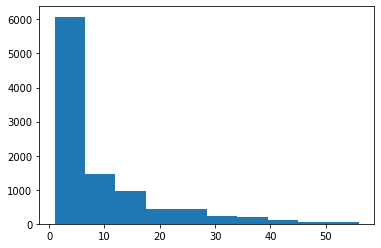

In [ ]:
bins, counts = raw_df.select('hitNumber').rdd.flatMap(lambda x: x).histogram(10)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([ 3.,  9.,  2., 14.,  6.,  2.,  0.,  0.,  0.,  4.]),
 array([10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]),
 <a list of 10 Patch objects>)

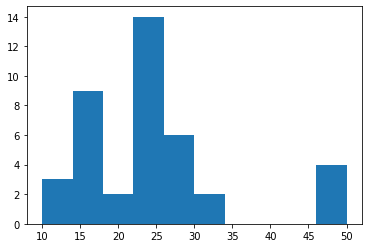

In [ ]:
bins, counts = raw_df.select('hitNumber') \
.filter(raw_df.hitAction_type == 6).rdd.flatMap(lambda x: x).histogram(10)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([302., 158.,  96., 112., 202., 319., 268., 431., 686., 942., 847.,
        931., 576., 229., 492., 696., 316., 356., 188., 209., 395., 368.,
        262., 618.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <a list of 24 Patch objects>)

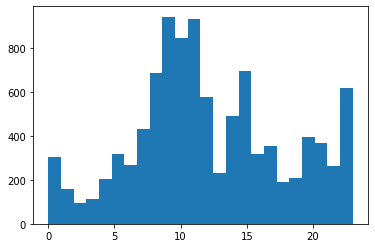

In [ ]:
bins, counts = raw_df.select('hitHour').rdd.flatMap(lambda x: x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([8., 4., 0., 0., 0., 0., 8., 0., 0., 0., 0., 0., 2., 6., 0., 0., 0.,
        0., 0., 0., 2., 0., 4., 6.]),
 array([ 6.        ,  6.58333333,  7.16666667,  7.75      ,  8.33333333,
         8.91666667,  9.5       , 10.08333333, 10.66666667, 11.25      ,
        11.83333333, 12.41666667, 13.        , 13.58333333, 14.16666667,
        14.75      , 15.33333333, 15.91666667, 16.5       , 17.08333333,
        17.66666667, 18.25      , 18.83333333, 19.41666667, 20.        ]),
 <a list of 24 Patch objects>)

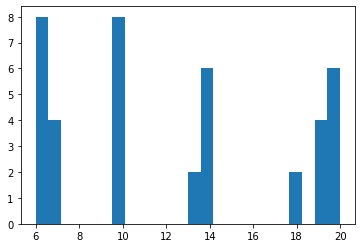

In [ ]:
bins, counts = raw_df.select('hitHour') \
.filter(raw_df.hitAction_type == 6).rdd.flatMap(lambda x: x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([1928., 2587., 2746., 2738.]),
 array([ 0.  , 14.75, 29.5 , 44.25, 59.  ]),
 <a list of 4 Patch objects>)

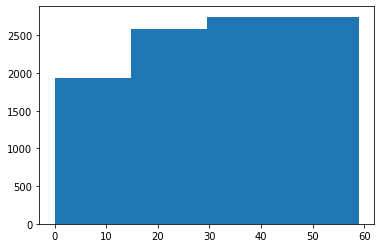

In [ ]:
bins, counts = raw_df.select('hitMin') \
.rdd.flatMap(lambda x: x).histogram(4)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([10., 12., 12.,  6.]),
 array([ 3. , 15.5, 28. , 40.5, 53. ]),
 <a list of 4 Patch objects>)

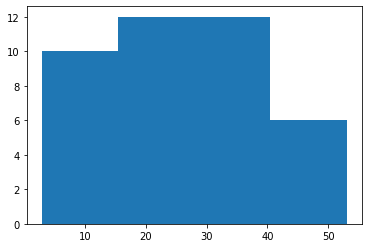

In [ ]:
bins, counts = raw_df.select('hitMin') \
.filter(raw_df.hitAction_type == 6).rdd.flatMap(lambda x: x).histogram(4)
plt.hist(bins[:-1], bins=bins, weights=counts)

In [ ]:
raw_df.groupBy('v2ProductName').count().sort(desc('count')).show(10, False)

+----------------------------------------------------+-----+
|v2ProductName                                       |count|
+----------------------------------------------------+-----+
|Google Men's 100% Cotton Short Sleeve Hero Tee White|211  |
|Google Men's 100% Cotton Short Sleeve Hero Tee Black|138  |
|Google Men's 100% Cotton Short Sleeve Hero Tee Navy |135  |
|Google Men's  Zip Hoodie                            |123  |
|22 oz YouTube Bottle Infuser                        |119  |
|Google Men's Watershed Full Zip Hoodie Grey         |119  |
|YouTube Men's Short Sleeve Hero Tee Black           |118  |
|YouTube Twill Cap                                   |107  |
|Google Women's Short Sleeve Hero Tee White          |106  |
|Google Women's Short Sleeve Hero Tee Black          |103  |
+----------------------------------------------------+-----+
only showing top 10 rows



In [ ]:
raw_df.filter(raw_df.hitAction_type == 6).describe().show()

+-------+-----------+--------------+--------+--------------------+----------------+------------------+---------+----------+-------+--------------+------------------+-----------------+------------------+-----------------+--------------------+---------------+-----------------+------------+------------------+-----------------------+
|summary|     source| sourceKeyword|  medium|       fullVisitorId|         visitId|              date|newVisits|hitReferer|hitType|hitAction_type|         hitNumber|          hitHour|            hitMin|     timeMicroSec|       v2ProductName|productListName|sessionQualityDim|timeOnScreen|        timeOnSite|totalTransactionRevenue|
+-------+-----------+--------------+--------+--------------------+----------------+------------------+---------+----------+-------+--------------+------------------+-----------------+------------------+-----------------+--------------------+---------------+-----------------+------------+------------------+-----------------------+
|  c

## Customer Behavior

In [ ]:
raw_df.select(countDistinct('fullVisitorId').alias('cnt_unique_user')).show()

+---------------+
|cnt_unique_user|
+---------------+
|            242|
+---------------+



In [ ]:
raw_df.filter(raw_df.hitAction_type == 6) \
.groupBy('fullVisitorId').count() \
.withColumnRenamed('count', 'cnt_purchase').show()

+-------------------+------------+
|      fullVisitorId|cnt_purchase|
+-------------------+------------+
|4990198874063509353|           4|
|4993519711854402788|           2|
|4989274933392395231|           6|
|4995584940873803432|           6|
|4993485206334150199|           2|
|4995899860057743088|           2|
|4988612949713423910|           4|
|4993852637585406336|           4|
|4995606827430436569|           2|
|4995924842281653133|           2|
|4993450863033496114|           4|
|4988683855814257726|           2|
+-------------------+------------+



In [ ]:
raw_df.filter(raw_df.hitAction_type == 6) \
.groupBy('visitId').count() \
.withColumnRenamed('count', 'cnt_purchase').show()

+----------+------------+
|   visitId|cnt_purchase|
+----------+------------+
|1486131356|           2|
|1470106850|           2|
|1490043910|           4|
|1492045051|           2|
|1498486477|           4|
|1477021389|           4|
|1474047117|           2|
|1488143869|           2|
|1485313789|           4|
|1487773059|           6|
|1487369367|           2|
|1497289186|           2|
|1494000490|           4|
+----------+------------+



In [ ]:
raw_df.filter(raw_df.visitId == 1486131356).show(25)

+--------+------------+-------------+------+---------+-------------------+----------+--------+---------+----------+-------+--------------+---------+-------+------+------------+--------------------+---------------+-------+------------+-----------------+------------+----------+-----------------------+
|  source|isTrueDirect|sourceKeyword|medium|isVideoAd|      fullVisitorId|   visitId|    date|newVisits|hitReferer|hitType|hitAction_type|hitNumber|hitHour|hitMin|timeMicroSec|       v2ProductName|productListName|isClick|isImpression|sessionQualityDim|timeOnScreen|timeOnSite|totalTransactionRevenue|
+--------+------------+-------------+------+---------+-------------------+----------+--------+---------+----------+-------+--------------+---------+-------+------+------------+--------------------+---------------+-------+------------+-----------------+------------+----------+-----------------------+
|(direct)|        true|         null|(none)|     null|4995924842281653133|1486131356|20170203|   

In [ ]:
raw_df.filter(raw_df.visitId == 1486131356).groupBy('hitAction_type').count().show()

+--------------+-----+
|hitAction_type|count|
+--------------+-----+
|             6|    2|
|             5|    2|
|             2|    1|
|             0|   15|
+--------------+-----+



In [ ]:
raw_df.groupBy('hitAction_type').count().show()

+--------------+-----+
|hitAction_type|count|
+--------------+-----+
|             1|  210|
|             6|   40|
|             3|   59|
|             5|   70|
|             4|   20|
|             2|  163|
|             0| 9437|
+--------------+-----+



# 3. Data Preparation

In [ ]:
# Drop columns
# 'source', 'sourceKeyword', 'isVideoAd', 'visitId', 'hitReferer', 'timeMicroSec', 'v2ProductName', 'timeOnScreen'

# onehot
# 'productListName', 'dayofweek', 'hitAction_type'

# standardization (don't need)
# 'timeOnSite', 'totalTransactionRevenue'

In [ ]:
df2 = raw_df.withColumn('isTrueDirect', when(raw_df.isTrueDirect == 'true', 1).otherwise(0)) \
.withColumn('medium_organic', when(raw_df.medium == 'organic', 1).otherwise(0)) \
.withColumn('dayofweek', dayofweek(to_date(col('date').cast('string'), 'yyyyMMdd'))) \
.withColumn('newVisits', when(raw_df.newVisits == '1', 1).otherwise(0)) \
.withColumn('hitType_page', when(raw_df.hitType == 'PAGE', 1).otherwise(0)) \
.withColumn('purchased', when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.withColumn('hitHour_00_02', when((raw_df.hitHour >= 0) & (raw_df.hitHour <= 2), 1).otherwise(0)) \
.withColumn('hitHour_03_05', when((raw_df.hitHour >= 3) & (raw_df.hitHour <= 5), 1).otherwise(0)) \
.withColumn('hitHour_06_08', when((raw_df.hitHour >= 6) & (raw_df.hitHour <= 8), 1).otherwise(0)) \
.withColumn('hitHour_09_11', when((raw_df.hitHour >= 9) & (raw_df.hitHour <= 11), 1).otherwise(0)) \
.withColumn('hitHour_12_14', when((raw_df.hitHour >= 12) & (raw_df.hitHour <= 14), 1).otherwise(0)) \
.withColumn('hitHour_15_17', when((raw_df.hitHour >= 15) & (raw_df.hitHour <= 17), 1).otherwise(0)) \
.withColumn('hitHour_18_20', when((raw_df.hitHour >= 18) & (raw_df.hitHour <= 20), 1).otherwise(0)) \
.withColumn('hitHour_21_23', when((raw_df.hitHour >= 21) & (raw_df.hitHour <= 23), 1).otherwise(0)) \
.withColumn('hitMin_00_14', when((raw_df.hitMin >= 0) & (raw_df.hitHour < 15), 1).otherwise(0)) \
.withColumn('hitMin_15_29', when((raw_df.hitMin >= 15) & (raw_df.hitHour < 30), 1).otherwise(0)) \
.withColumn('hitMin_30_44', when((raw_df.hitMin >= 30) & (raw_df.hitHour < 45), 1).otherwise(0)) \
.withColumn('hitMin_45_60', when((raw_df.hitMin >= 45) & (raw_df.hitHour < 60), 1).otherwise(0)) \
.withColumn('isClick', when(raw_df.isClick, 1).otherwise(0)) \
.withColumn('isImpression', when(raw_df.isImpression, 1).otherwise(0)) \
.withColumn('hitaction_1', when(raw_df.hitAction_type == 1, 1).otherwise(0)) \
.withColumn('hitaction_2', when(raw_df.hitAction_type == 2, 1).otherwise(0)) \
.withColumn('hitaction_3', when(raw_df.hitAction_type == 3, 1).otherwise(0)) \
.withColumn('hitaction_4', when(raw_df.hitAction_type == 4, 1).otherwise(0)) \
.withColumn('hitaction_5', when(raw_df.hitAction_type == 5, 1).otherwise(0)) \
.withColumn('hitaction_6', when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.na.fill(value=0, subset=['timeOnSite', 'sessionQualityDim', 'totalTransactionRevenue'])
# .drop('source', 'medium', 'date', 'hitType', 'hitHour', 'hitMin', 'sourceKeyword', 'isVideoAd', 'fullVisitorId', 'visitId', 'hitReferer', 'timeMicroSec', 'v2ProductName', 'timeOnScreen')

In [ ]:
df2.show()

+------+------------+--------------+-------+---------+-------------------+----------+--------+---------+----------+-------+--------------+---------+-------+------+------------+--------------------+----------------+-------+------------+-----------------+------------+----------+-----------------------+--------------+---------+------------+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+
|source|isTrueDirect| sourceKeyword| medium|isVideoAd|      fullVisitorId|   visitId|    date|newVisits|hitReferer|hitType|hitAction_type|hitNumber|hitHour|hitMin|timeMicroSec|       v2ProductName| productListName|isClick|isImpression|sessionQualityDim|timeOnScreen|timeOnSite|totalTransactionRevenue|medium_organic|dayofweek|hitType_page|purchased|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_1

In [ ]:
df2.filter(df2.hitaction_6 >= 1).groupBy('productListName').count().show()

+---------------+-----+
|productListName|count|
+---------------+-----+
|      (not set)|   40|
+---------------+-----+



In [ ]:
df3 = df2.groupBy('fullVisitorId', 'visitId', 'v2ProductName', 
                  'isTrueDirect', 'medium_organic', 'dayofweek',
                  'newVisits', 'hitType_page',
                  'hitHour_00_02', 'hitHour_03_05', 'hitHour_06_08', 'hitHour_09_11', 
                  'hitHour_12_14', 'hitHour_15_17',  'hitHour_18_20', 'hitHour_21_23', 
                  ) \
.agg(sum('hitaction_1').alias('sum_hitaction_1')
, sum('hitaction_2').alias('sum_hitaction_2')
, sum('hitaction_3').alias('sum_hitaction_3')
, sum('hitaction_4').alias('sum_hitaction_4')
, sum('hitaction_5').alias('sum_hitaction_5')
, sum('hitaction_6').alias('sum_hitaction_6')
, max('hitNumber').alias('hitNumber')
, max('timeOnSite').alias('timeOnSite')
, max('sessionQualityDim').alias('sessionQualityDim')
, max('totalTransactionRevenue').alias('totalTransactionRevenue')
, max('isClick').alias('isClick')
, max('isImpression').alias('isImpression')
)

In [ ]:
df3 = df3.withColumn('target', when(df3.sum_hitaction_6 >= 1, 1).otherwise(0))

In [ ]:
df3.filter(df3.visitId == 1486131356).show(25, False)

+-------------------+----------+---------------------------------------------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+-------+------------+------+
|fullVisitorId      |visitId   |v2ProductName                                      |isTrueDirect|medium_organic|dayofweek|newVisits|hitType_page|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_12_14|hitHour_15_17|hitHour_18_20|hitHour_21_23|sum_hitaction_1|sum_hitaction_2|sum_hitaction_3|sum_hitaction_4|sum_hitaction_5|sum_hitaction_6|hitNumber|timeOnSite|sessionQualityDim|totalTransactionRevenue|isClick|isImpression|target|
+-------------------+----------+---------------------------------------------------+------------+-------------

In [ ]:
df3.describe().show()

+-------+--------------------+--------------------+--------------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+------------------+-----------------------+--------------------+-------------------+--------------------+
|summary|       fullVisitorId|             visitId|       v2ProductName|      isTrueDirect|    medium_organic|        dayofweek|         newVisits|       hitType_page|      hitHour_00_02|      hitHour_03_05|      hitHour_06_08|      hitHour_09_11|      hitHour_12_14|     hitHour_15_17|      hitHour_18_20|     hitHour_21_23|     sum_hitaction_1|     sum_hitaction_2|     sum_hitaction_3|     sum_hitaction_

In [ ]:
df3.select([count(when(isnan(c), c)).alias(c) for c in df3.columns]).show()

+-------------+-------+-------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+-------+------------+------+
|fullVisitorId|visitId|v2ProductName|isTrueDirect|medium_organic|dayofweek|newVisits|hitType_page|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_12_14|hitHour_15_17|hitHour_18_20|hitHour_21_23|sum_hitaction_1|sum_hitaction_2|sum_hitaction_3|sum_hitaction_4|sum_hitaction_5|sum_hitaction_6|hitNumber|timeOnSite|sessionQualityDim|totalTransactionRevenue|isClick|isImpression|target|
+-------------+-------+-------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------

In [ ]:
df3.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- isTrueDirect: integer (nullable = false)
 |-- medium_organic: integer (nullable = false)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitType_page: integer (nullable = false)
 |-- hitHour_00_02: integer (nullable = false)
 |-- hitHour_03_05: integer (nullable = false)
 |-- hitHour_06_08: integer (nullable = false)
 |-- hitHour_09_11: integer (nullable = false)
 |-- hitHour_12_14: integer (nullable = false)
 |-- hitHour_15_17: integer (nullable = false)
 |-- hitHour_18_20: integer (nullable = false)
 |-- hitHour_21_23: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = tr

In [ ]:
df3.groupBy('sum_hitaction_1', 'target').count().sort('sum_hitaction_1').show()

+---------------+------+-----+
|sum_hitaction_1|target|count|
+---------------+------+-----+
|              0|     1|   20|
|              0|     0| 7466|
|              1|     0|   71|
|              2|     0|   48|
|              3|     0|    8|
|              4|     0|    2|
|              5|     0|    1|
|              6|     0|    1|
+---------------+------+-----+



In [ ]:
df3.groupBy('sum_hitaction_2', 'target').count().sort('sum_hitaction_2').show()

+---------------+------+-----+
|sum_hitaction_2|target|count|
+---------------+------+-----+
|              0|     1|    6|
|              0|     0| 7478|
|              1|     1|   13|
|              1|     0|  103|
|              2|     1|    1|
|              2|     0|    8|
|              3|     0|    5|
|              4|     0|    1|
|              5|     0|    2|
+---------------+------+-----+



In [ ]:
df3.groupBy('sum_hitaction_3', 'target').count().sort('sum_hitaction_3').show()

+---------------+------+-----+
|sum_hitaction_3|target|count|
+---------------+------+-----+
|              0|     1|   20|
|              0|     0| 7544|
|              1|     0|   50|
|              2|     0|    2|
|              5|     0|    1|
+---------------+------+-----+



In [ ]:
df3.groupBy('sum_hitaction_4', 'target').count().sort('sum_hitaction_4').show()

+---------------+------+-----+
|sum_hitaction_4|target|count|
+---------------+------+-----+
|              0|     0| 7579|
|              0|     1|   20|
|              1|     0|   16|
|              2|     0|    2|
+---------------+------+-----+



In [ ]:
df3.groupBy('sum_hitaction_5', 'target').count().sort('sum_hitaction_5').show()

+---------------+------+-----+
|sum_hitaction_5|target|count|
+---------------+------+-----+
|              0|     0| 7593|
|              1|     1|    3|
|              1|     0|    2|
|              2|     1|    5|
|              2|     0|    1|
|              3|     1|    3|
|              3|     0|    1|
|              4|     1|    7|
|              5|     1|    1|
|              8|     1|    1|
+---------------+------+-----+



## Data Encoding

In [ ]:
# productList_indexer = StringIndexer(inputCol='productListName', outputCol='productList_index')
# productList_ohe = OneHotEncoder(inputCol='productList_index', outputCol='productList_vec')

In [ ]:
# onehot_encoder = OneHotEncoder(inputCols=['hitAction_type', 'dayofweek'], outputCols=['hitAction_type_vec', 'dayofweek_vec'])
onehot_encoder = OneHotEncoder(inputCols=['dayofweek'], outputCols=['dayofweek_vec'])

In [ ]:
label_stringIdx = StringIndexer(inputCol = 'target', outputCol = 'label')

In [ ]:
df3.schema.names

['fullVisitorId',
 'visitId',
 'v2ProductName',
 'isTrueDirect',
 'medium_organic',
 'dayofweek',
 'newVisits',
 'hitType_page',
 'hitHour_00_02',
 'hitHour_03_05',
 'hitHour_06_08',
 'hitHour_09_11',
 'hitHour_12_14',
 'hitHour_15_17',
 'hitHour_18_20',
 'hitHour_21_23',
 'sum_hitaction_1',
 'sum_hitaction_2',
 'sum_hitaction_3',
 'sum_hitaction_4',
 'sum_hitaction_5',
 'sum_hitaction_6',
 'hitNumber',
 'timeOnSite',
 'sessionQualityDim',
 'totalTransactionRevenue',
 'isClick',
 'isImpression',
 'target']

In [ ]:
# vector_assembler = VectorAssembler\
# (inputCols = ['isTrueDirect', 'newVisits', 'hitAction_type_vec', 'hitNumber', 'isClick', 'isImpression', 'sessionQualityDim', 'timeOnSite', 'totalTransactionRevenue', \
#  'medium_organic', 'hitType_page', 'hitHour_00_02', 'hitHour_03_05', 'hitHour_06_08', 'hitHour_09_11', 'hitHour_12_14', 'hitHour_15_17', 'hitHour_18_20', \
#  'hitHour_21_23', 'hitMin_00_14', 'hitMin_15_29', 'hitMin_30_44', 'hitMin_45_60', \
#  'dayofweek_vec', 'hitAction_type_vec', 'productList_vec'], outputCol = 'features')

In [ ]:
vector_assembler = VectorAssembler\
(inputCols = ['isTrueDirect',
 'medium_organic',
 'dayofweek_vec',
 'newVisits',
 'hitType_page',
 'hitHour_00_02',
 'hitHour_03_05',
 'hitHour_06_08',
 'hitHour_09_11',
 'hitHour_12_14',
 'hitHour_15_17',
 'hitHour_18_20',
 'hitHour_21_23',
 'sum_hitaction_1',
 'sum_hitaction_2',
 'sum_hitaction_3',
 'sum_hitaction_4',
#  'sum_hitaction_5',
#  'sum_hitaction_6',
 'hitNumber',
 'timeOnSite',
 'sessionQualityDim',
 'isClick',
 'isImpression'], outputCol = 'features')

In [ ]:
# pipeline = Pipeline(stages=[productList_indexer, productList_ohe, onehot_encoder, label_stringIdx, vector_assembler])
pipeline = Pipeline(stages=[onehot_encoder, label_stringIdx, vector_assembler])


In [ ]:
final_df = pipeline.fit(df3).transform(df3)
final_df.show()

+-------------------+----------+--------------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+-------+------------+------+-------------+-----+--------------------+
|      fullVisitorId|   visitId|       v2ProductName|isTrueDirect|medium_organic|dayofweek|newVisits|hitType_page|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_12_14|hitHour_15_17|hitHour_18_20|hitHour_21_23|sum_hitaction_1|sum_hitaction_2|sum_hitaction_3|sum_hitaction_4|sum_hitaction_5|sum_hitaction_6|hitNumber|timeOnSite|sessionQualityDim|totalTransactionRevenue|isClick|isImpression|target|dayofweek_vec|label|            features|
+-------------------+----------+--------------------+------------+--------------+---------

## Split data

In [ ]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=49)
print("Training Dataset: " + str(train_df.count()))
print("Test Dataset: " + str(test_df.count()))

Training Dataset: 6065
Test Dataset: 1552


In [ ]:
train_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 6047|
|  1.0|   18|
+-----+-----+



In [ ]:
test_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 1550|
|  1.0|    2|
+-----+-----+



## Oversampling

In [ ]:
balanceRatio = train_df.filter(col('label') == 1).count() / train_df.count()

In [ ]:
balanceRatio

0.002967848309975268

In [ ]:
calWeight = udf(lambda x: 1 * balanceRatio if x == 0 else (1 * (1.0 - balanceRatio)), DoubleType())

In [ ]:
weighted_df = train_df.withColumn('class_weight', calWeight('label'))

# 4. Modeling

In [ ]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features', weightCol='class_weight', seed=49)

In [ ]:
rfModel = rf.fit(weighted_df)

In [ ]:
result_df = rfModel.transform(test_df.dropna())

In [ ]:
result_df.select(['label', 'prediction']).filter(result_df.label == 1).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       0.0|
+-----+----------+



In [ ]:
result_df.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1543|
|       1.0|    9|
+----------+-----+



In [ ]:
rfModel.featureImportances

SparseVector(28, {0: 0.0283, 1: 0.0145, 3: 0.0029, 4: 0.0054, 5: 0.014, 6: 0.0157, 7: 0.0028, 8: 0.0184, 9: 0.0498, 10: 0.0021, 11: 0.0002, 12: 0.004, 13: 0.0071, 14: 0.0084, 15: 0.0033, 16: 0.0145, 17: 0.0715, 18: 0.0039, 19: 0.0039, 20: 0.1987, 21: 0.0003, 23: 0.3322, 24: 0.1417, 25: 0.0, 26: 0.0015, 27: 0.0549})

In [ ]:
rfModel.getNumTrees

20

# 5. Evaluation

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
print('Area Under ROC = %g' % evaluator.evaluate(result_df))

Area Under ROC = 0.747419


In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')
print('F1 score = %g' % evaluator.evaluate(result_df))
print('Precision = %g' % evaluator.evaluate(result_df, {evaluator.metricName: 'precisionByLabel'}))
print('Recall = %g' % evaluator.evaluate(result_df, {evaluator.metricName: 'recallByLabel'}))

F1 score = 0.99604
Precision = 0.999352
Recall = 0.994839


## Tuning

In [ ]:
paramGrid = ParamGridBuilder() \
.addGrid(rf.numTrees, [20, 50, 100]) \
.build()

In [ ]:
crossval = CrossValidator(estimator=rf, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=BinaryClassificationEvaluator(), 
                          numFolds=5)

In [ ]:
cvModel = crossval.fit(weighted_df)

In [ ]:
result_cv_df = cvModel.transform(test_df.dropna())

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
print('Area Under ROC = %g' % evaluator.evaluate(result_cv_df))

Area Under ROC = 0.747097


# 6. Deployment

REST API